<a href="https://colab.research.google.com/github/francisbonheur/alyra_projet_deep_learning/blob/main/violence_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, Image as IPImage, display
import warnings
import os
from pathlib import Path
warnings.filterwarnings('ignore')

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import image_dataset_from_directory


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdulmananraja/real-life-violence-situations")

data_dir = path + "/new_violence"

print("Path to dataset files:", data_dir)


100%|██████████| 225M/225M [00:21<00:00, 10.7MB/s] 

Extracting files...


Path to dataset files: C:\Users\sicet\.cache\kagglehub\datasets\abdulmananraja\real-life-violence-situations\versions\1/new_violence


In [9]:
print("🔧 Préparation des datasets...\n")

# Paramètres
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
VALIDATION_SPLIT = 0.2
SEED = 42

# IMPORTANT : Spécifier explicitement les classes valides pour éviter d'inclure des dossiers non-désirés
valid_class_names = ['non_violence', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Créer le dataset d'entraînement avec filtrage des classes
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred'
)

# Créer le dataset de validation avec les mêmes classes
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred'
)

# Obtenir les noms de classes (devrait être les 5 classes de fleurs)
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"✅ Datasets créés !\n")
print(f"📊 Information sur les datasets :")
print(f"  - Classes        : {class_names}")
print(f"  - Nombre de classes : {num_classes}")

# Vérification de sécurité
if num_classes != 2:
    print(f"\n⚠️  ERREUR : {num_classes} classes détectées au lieu de 2 !")
    print(f"   Classes trouvées : {class_names}")
else:
    print(f"  - ✅ Nombre de classes correct : 2")

print(f"\n  - Train batches  : {len(train_ds)}")
print(f"  - Val batches    : {len(val_ds)}")
print(f"  - Batch size     : {BATCH_SIZE}")
print(f"  - Image size     : {IMG_SIZE}")
print(f"\n  - Train samples  : ~{len(train_ds) * BATCH_SIZE}")
print(f"  - Val samples    : ~{len(val_ds) * BATCH_SIZE}")

🔧 Préparation des datasets...

Found 11073 files belonging to 2 classes.
Using 8859 files for training.
Found 11073 files belonging to 2 classes.
Using 2214 files for validation.
✅ Datasets créés !

📊 Information sur les datasets :
  - Classes        : ['non_violence', 'violence']
  - Nombre de classes : 2
  - ✅ Nombre de classes correct : 2

  - Train batches  : 277
  - Val batches    : 70
  - Batch size     : 32
  - Image size     : (224, 224)

  - Train samples  : ~8864
  - Val samples    : ~2240


In [13]:
def create_cnn_model():
    """
    Crée un réseau de neurones convolutif à 3 blocs de convolution.
    """
    model = keras.Sequential([
        # Premier bloc convolutif : 32 filtres 3x3
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), 
                     padding='same', name='conv_1'),
        layers.MaxPooling2D((2, 2), name='pool_1'),
        
        # Deuxième bloc convolutif : 64 filtres 3x3
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'),
        layers.MaxPooling2D((2, 2), name='pool_2'),
        
        # Troisième bloc convolutif : 128 filtres 3x3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'),
        
        # Aplatissement pour les couches denses
        layers.Flatten(name='flatten'),
        
        # Couches denses finales
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.Dropout(0.5, name='dropout'),
        
        # Couche de sortie
        layers.Dense(1, activation='sigmoid', name='output')
    ])
    
    return model

# Création du modèle
cnn_model = create_cnn_model()

# Affichage de l'architecture
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    51,380,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,473,729 (196.36 MB)

 Trainable params: 51,473,729 (196.36 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

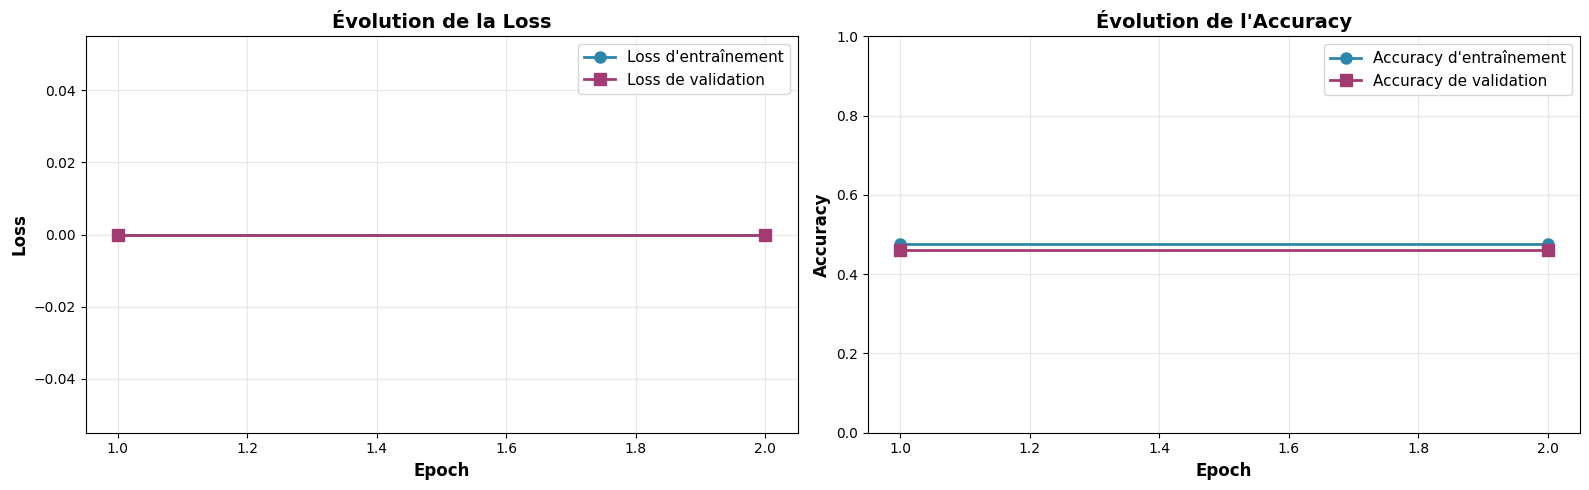


Epoch 2/15
Loss: 0.0000 - Accuracy: 0.4750
Val Loss: 0.0000 - Val Accuracy: 0.4621


In [ ]:
from tensorflow.keras.callbacks import Callback

class LivePlotCallback(Callback):
    """
    Callback personnalisé pour visualiser les métriques en temps réel pendant l'entraînement.
    """
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.loss = []
        self.val_loss = []
        self.accuracy = []
        self.val_accuracy = []
        
    def on_epoch_end(self, epoch, logs=None):
        # Enregistrement des métriques
        self.epochs.append(epoch + 1)
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        
        # Effacement et redessin
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        
        # Graphique de la loss
        ax1.plot(self.epochs, self.loss, 'o-', label='Loss d\'entraînement', 
                linewidth=2, markersize=8, color='#2E86AB')
        ax1.plot(self.epochs, self.val_loss, 's-', label='Loss de validation', 
                linewidth=2, markersize=8, color='#A23B72')
        ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
        ax1.set_title('Évolution de la Loss', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(alpha=0.3)
        
        # Graphique de l'accuracy
        ax2.plot(self.epochs, self.accuracy, 'o-', label='Accuracy d\'entraînement', 
                linewidth=2, markersize=8, color='#2E86AB')
        ax2.plot(self.epochs, self.val_accuracy, 's-', label='Accuracy de validation', 
                linewidth=2, markersize=8, color='#A23B72')
        ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax2.set_title('Évolution de l\'Accuracy', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(alpha=0.3)
        ax2.set_ylim([0, 1])
        
        plt.tight_layout()
        plt.show()
        
        # Affichage textuel
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")
        print(f"Loss: {logs.get('loss'):.4f} - Accuracy: {logs.get('accuracy'):.4f}")
        print(f"Val Loss: {logs.get('val_loss'):.4f} - Val Accuracy: {logs.get('val_accuracy'):.4f}")

# Création d'un nouveau callback
live_plot_cnn = LivePlotCallback()

# Entraînement
print("🚀 Début de l'entraînement du modèle CNN...\n")

history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    batch_size=128,
    callbacks=[live_plot_cnn],
    verbose=0
)